# Single Variate LSTM Model

To explore the computational performance of our model, I will investigate whether a univariate LSTM model would be appropriate. Essentially, we would model the pollution at future time steps based solely on historical pollution data.

We decided to explore this approach because, based on the correlation and lag data presented in our EDA, we hypothesize that pollution data—specifically from the previous time step—may be the most relevant predictor for our model. As we look into the scalability of our model, the goal is to reduce complexity to decrease computation time without sacrificing too much accuracy. Additionally, if we can eliminate irrelevant noise from the model, it will be highly beneficial.

In [14]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import tensorflow as tf
import psutil

In [15]:
df = pd.read_csv('LSTM-Multivariate_pollution.csv')
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

df.wnd_dir = df.wnd_dir.map(mapping)

I will now scale the data and split into training and test data. We have decided on using a 90% split of data, and as it is time series data we will use the first 90% as training and last 10% as test.

In [16]:
df_scaled=df.copy()

scaler = MinMaxScaler()

df_scaled['date'] = pd.to_datetime(df_scaled['date'])

df_scaled.set_index('date', inplace=True)
    
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd',
       'snow', 'rain'])
    
df_scaled = df_scaled[columns]
df_scaled[columns] = scaler.fit_transform(df_scaled[columns])


df_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [17]:
df_scaled=df_scaled['pollution'] #drop all columns for univariate apart from pollution and date
df_scaled.head()

date
2010-01-02 00:00:00    0.129779
2010-01-02 01:00:00    0.148893
2010-01-02 02:00:00    0.159960
2010-01-02 03:00:00    0.182093
2010-01-02 04:00:00    0.138833
Name: pollution, dtype: float64

In [18]:
train_size = int(len(df) * 0.9)  # 90% for training
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

print(f"Training data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (39420,)
Test data size: (4380,)


## Moving window validation 
In LSTM models, regular cross-validation methods are not appropriate. This is because cross-validation assumes independence between data points, which does not hold for time series data. In time series models, past values are often highly relevant to predicting future values, as the data exhibits temporal dependencies. Additionally, with traditional cross-validation, there is a risk of data leakage. This occurs when the data is randomly split into training and testing sets, potentially allowing future information to influence the training process. This violates the temporal order of the data, where future values should not be used to predict past ones.

Hence we will use moving window validation instead, which ensures data used when making predictions is only from pasa data



In [19]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])  # Sequence of pollution values
        labels.append(data[i+sequence_length])  # Next time step's pollution value (target)
    return np.array(sequences), np.array(labels)

X_train, y_train = create_sequences(train_data, 10)
X_test, y_test = create_sequences(test_data, 10)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

/var/folders/zj/y_2y230d1z18y9001xkg2qgw0000gn/T/ipykernel_52399/2350922260.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(data[i+sequence_length])  # Next time step's pollution value (target)


X_train shape: (39410, 10), y_train shape: (39410,)
X_test shape: (4370, 10), y_test shape: (4370,)


In [20]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Basic LSTM model

To start with we will use a large number of epochs of 100, and then look to implement early stopping to improve training time and reduce overfitting. The rest of the hyperparameters chosen are pretty standard when it comes to LSTM models which I will look at adjusting a few later on in relation to improving computation time and GPU performance. For instance batch size will be investigated, which is the number samples of data in a mini batch, which the model does a forward and backward pass on in each epoch. 

Throughout our testing of the models, we will evaluate performance based on both loss (training and validation loss, using mean squared error) and RMSE. Additionally, we will assess GPU performance and training time to draw conclusions about the impact of different modifications to the model.

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


This is due to looking at the hardware requirements for using GPUs on tensorflow on https://www.tensorflow.org/install/pip#windows-native we can see that there is "There is currently no official GPU support for MacOS". As I can not install tensorflow-metal, I will continue to conduct analysis using the version running on CPU, looking at the CPU performance.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


CPU Usage Before Training: 13.1%
Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0496 - val_loss: 7.6091e-04 - val_root_mean_squared_error: 0.0276
Epoch 2/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2817e-04 - root_mean_squared_error: 0.0304 - val_loss: 5.4717e-04 - val_root_mean_squared_error: 0.0234
Epoch 3/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.3544e-04 - root_mean_squared_error: 0.0305 - val_loss: 4.9730e-04 - val_root_mean_squared_error: 0.0223
Epoch 4/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.9475e-04 - root_mean_squared_error: 0.0281 - val_loss: 5.3513e-04 - val_root_mean_squared_error: 0.0231
Epoch 5/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.0559e-04 - root_mean_squared_error: 0.0284 - val_loss: 5.0432e-04 - val_root_mean_squared_error: 0.0225
Epoch 6/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.6192e-04 - root_mean_squared_error: 0.0293 - val_loss: 4.9155e-04 - val_r

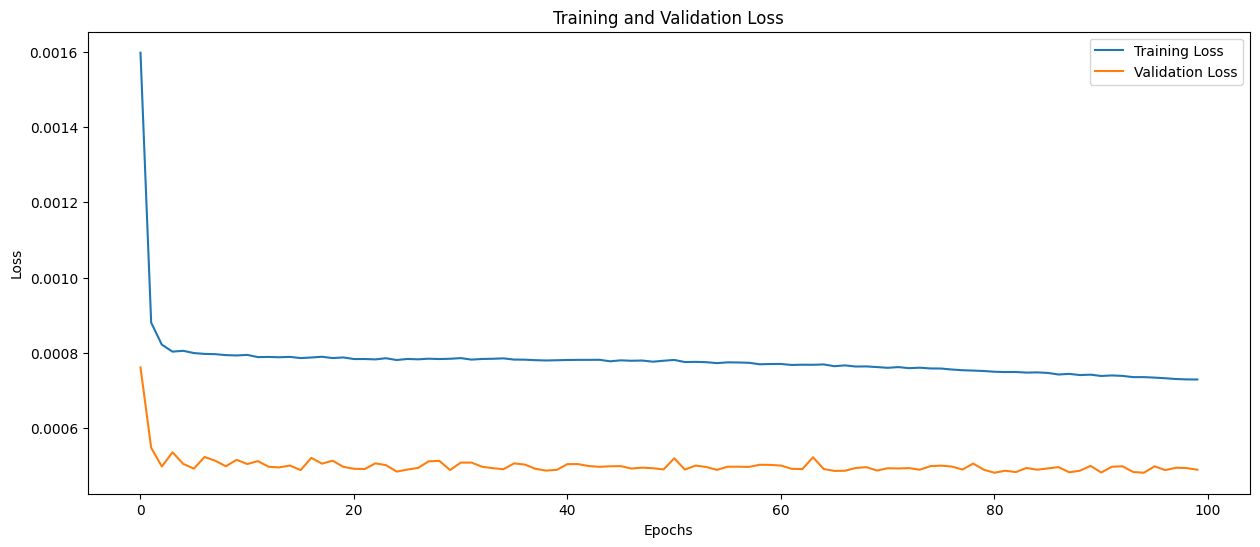

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

cpu_usage_before = psutil.cpu_percent(interval=1)
print(f"CPU Usage Before Training: {cpu_usage_before}%")

start_time = time.time() #time taken for model to run

history = model.fit(
    X_train, y_train, 
    epochs=100,                  
    batch_size=64,                
    validation_data=(X_test, y_test))

cpu_usage_after = psutil.cpu_percent(interval=1)
print(f"CPU Usage After Training: {cpu_usage_after}%")

cpu_load_during_training = psutil.cpu_percent(interval=1)
print(f"CPU Load During Training: {cpu_load_during_training}%")

print("Training Time: ", time.time() - start_time)

# Plot training and validation loss over epochs
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





## Early Stopping

Lets see if we can reduce overfitting and training time.

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',          # Metric to monitor (could be 'val_accuracy', 'val_loss', etc.)
    patience=10,                 # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,   # Restore the model with the best weights after training ends
    verbose=1                    # Print messages when early stopping is triggered
)

start_time = time.time() #time taken for model to run
# Train the model with early stopping
history = model.fit(
    X_train, y_train, 
    epochs=100,                   # Max number of epochs
    batch_size=64,                # Batch size
    validation_data=(X_test, y_test),  # Validation data for early stopping to monitor
     callbacks=[early_stopping]    # Pass the early stopping callback
)
print("Training Time: ", time.time() - start_time)

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.summary()


Epoch 1/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.3231e-04 - root_mean_squared_error: 0.0270 - val_loss: 4.8451e-04 - val_root_mean_squared_error: 0.0220
Epoch 2/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.6829e-04 - root_mean_squared_error: 0.0258 - val_loss: 4.7786e-04 - val_root_mean_squared_error: 0.0219
Epoch 3/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.7197e-04 - root_mean_squared_error: 0.0277 - val_loss: 4.8015e-04 - val_root_mean_squared_error: 0.0219
Epoch 4/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.5925e-04 - root_mean_squared_error: 0.0257 - val_loss: 4.8946e-04 - val_root_mean_squared_error: 0.0221
Epoch 5/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3149e-04 - root_mean_squared_error: 0.0270 - val_loss: 4.8052e-04 - val_root_mean_squared_error: 0.0219
Epoch 6/100
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.9064e-04 - root_mean_squared_error: 0.0262 - val_loss: 4.7522e-04 - val_root_mean_squared_error: 0.021

KeyboardInterrupt: 

As we can see, the number of optimal epochs is considered to be 14, reducing the training time to 50 seconds from 207 seconds.

In [61]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actual
0,0.115363,0.101610
1,0.100706,0.111670
2,0.111688,0.110664
3,0.110435,0.134809
4,0.135898,0.170020


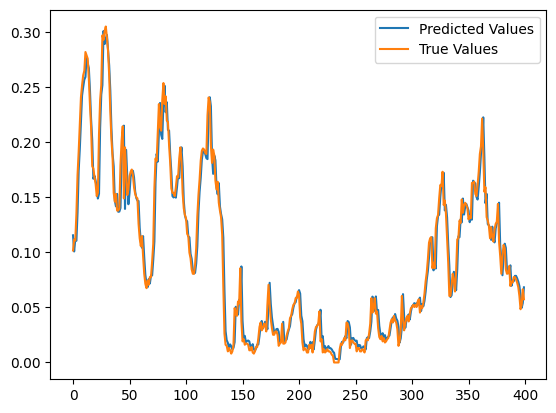

In [62]:
plt.plot(test_results['Train Predictions'][:400], label='Predicted Values')
plt.plot(test_results['Actual'][:400], label='True Values')
plt.legend()
plt.show()

In [63]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.02180
